In [32]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
# plt.style.use('max_style.mplstyle')

from numba.experimental import jitclass
import numba as nb
from scipy.interpolate import interp1d

from tqdm import tqdm
from time import time
from spl import spline
from scipy.optimize import minimize

from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
import seaborn as sns
from sklearn.metrics import mean_squared_error
import matplotlib.patches as patches
import matplotlib.colors as mcolors 

%matplotlib inline

# <center>Define Verlet and System Base Class</center><a id="first-bullet"></a>

In [33]:
class verlet():
    def getAcc(self, positions, _):
        """
        simple harmonic oscillator.
        This is for testing purposes. The user should 
        overload this function in order to implement the system
        that should be simulated. 
        (like multiple ions interact with eachother)
        """
        
        return -positions
    
    def integrate(self, endtime, dt):
        """
        calculate the trajectory for N Ions in M Dimensions.
        implemented shortened velocity verlet from:
        https://en.wikipedia.org/wiki/Verlet_integration
        assumes, that acceleration only depends on position.

        Parameters
        ----------
        self.getAcc : function(array) : array
            verlet integrates only, so acceleration function
            needs to implemented by the user!
            see getAcc docstring

        endtime : float
            Seconds on where to end simulation.

        dt : float
            step size between each evaluation step in Seconds.
            With our setup of iontraps less or equal to
            5e-9 is recommended! (redtrap)

        Returns
        -------
        tpoints : np.array
            points of all evaluated timesteps

        ppoints : np.array
            ppoints[:, 0, 0, 0]
                    |  |  |  |
                    |  |  |  > dimension x (or general 1st dim)
                    |  |  > 0 is position, 
                    |  |    1 velocity, 2 acceleration
                    |  > choose ion #0
                    > all timesteps
        """

        n = int(endtime / dt)
        shape = (n,) + self.ions.shape
        tpoints = np.linspace(0, endtime, n)
        ppoints = np.empty(shape, dtype=np.float64)

        ppoints[0] = self.ions

        # iterate through all timepoints, see wiki link in docstring
        for k in range(len(tpoints)-1):
            ppoints[k+1, :, 0] = ppoints[k, :, 0] + ppoints[k, :, 1] * dt + 0.5 * ppoints[k, :, 2] * dt**2
            ppoints[k+1, :, 2] = self.getAcc(ppoints[k+1, :, 0, 0], k+1)
            ppoints[k+1, :, 1] = ppoints[k, :, 1] + 0.5 * (ppoints[k, :, 2] + ppoints[k+1, :, 2]) * dt

        return tpoints, ppoints

In [34]:
spec = [('ions', nb.float64[:, :, :]),
        ('trap', nb.float64[:, :, :]),
        ('splcoeff', nb.float64[:, :, :]),
        ('volt', nb.float64[:, :]),
        ('qdm', nb.float64),]

@jitclass(spec)
class red_system(verlet, spline):
    def __init__(self, trap):
        
        self.splcoeff = np.empty(trap.shape)
        
        for i in range(len(trap)):
            self.splcoeff[i, 0] = self.splrep(trap[i, 0], trap[i, 1])
            self.splcoeff[i, 1] = self.splrep(trap[i, 0], trap[i, 2])
        
        self.trap = trap
        
        q = 1.60217662e-19
        m = 1.66054e-27*39.96259
        self.qdm = q/m
        
    def propagate(self, ramp, endtime, dt):
        n = int(endtime / dt)
        tpoints = np.linspace(0, endtime, n)
    
        self.volt = np.zeros((len(ramp)-1, n))
        for i in range(len(ramp)-1):
            self.volt[i] = np.interp(tpoints, ramp[0], ramp[i+1])

        return self.integrate(endtime, dt)
        
        
    def setIons(self, positions):
        """
        set the initial positions of the ions.
        
        Parameters
        ----------
        posistions : np.array
            has size (#numberOfIons, positions).
            For one dim (x, 3, 1), for 3 dim (x, 3, 3)
            with position, velocity, acceleration
        """
        self.ions = positions
    
    def getAcc(self, position, k):
        acc = np.zeros(position.shape)
        
        for i in range(len(self.trap)):
            acc += self.volt[i, k] * self.splev(position, self.trap[i, 0], self.trap[i, 2], self.splcoeff[i, 1])
            
        return acc * self.qdm
    
    def getPot(self, position, k):
        # TODO find out what k is
        pot = np.zeros(position.shape)
        
        for i in range(len(self.trap)):
            pot += self.volt[i, k] * self.splev(position, self.trap[i, 0], self.trap[i, 1], self.splcoeff[i, 0])
            
        return pot

### load trap geometry <a id="load-trap-geometry"></a>

In [35]:
trap = np.load('redtrap.npy')
trap[:, 0] *= 1e-3
trap[:, 1:] *= 2
print(trap.shape[0])

16


## Plot the Poential with 1V applied
(multiply with any value; potential scales linearly with applied voltage)


### Task:
- read the paper from Ferdinand and calculate the trap frequency with the potential below

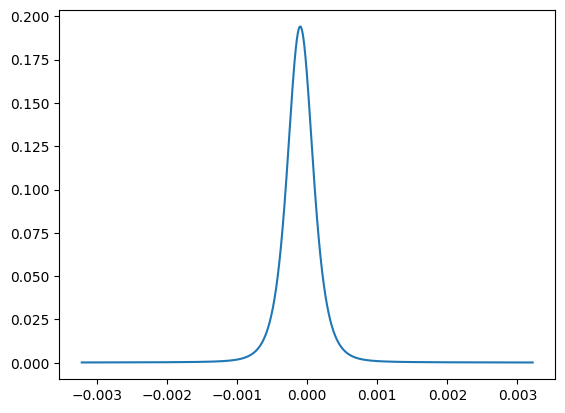

In [36]:
plt.plot(trap[15, 0], trap[15,1])

In [37]:
x1 = trap[15,0]         # m (array)
V_eV = trap[15,1]      # eV

eV2J = 1.602176634e-19
V = V_eV * eV2J
m_Ca40 = 39.962590866 * 1.66053906660e-27  # kg

# find center (closest to x=0)
i_center = int(np.argmin(np.abs(x1)))
x0 = x1[i_center]

# small window around center (adjust window size if you want)
window = 11
half = window//2
i0 = max(i_center-half, 0)
i1 = min(i_center+half+1, len(x1))

xs = x1[i0:i1] - x0
Vs = V[i0:i1]

# quadratic fit
a, b, c = np.polyfit(xs, Vs, 2)
d2Vdx2 = 2*a

# because d2Vdx2 < 0 at a peak, use -d2Vdx2
omega = np.sqrt(abs(d2Vdx2)/m_Ca40)
freq = omega / (2*np.pi)

print("frequency =", freq, "Hz")


frequency = 429141.9376772995 Hz


## Find out whether the middle of segment 15 is nummerically also the minima of the potential

x should be:

x: [-1.000e-04]

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -0.1941244313729034
        x: [-1.000e-04]
      nit: 4
      jac: [ 3.725e-09]
 hess_inv: [[ 1.499e-07]]
     nfev: 30
     njev: 15
---------------
x_min: -9.909909909909921e-05
y_min: -0.1941217236569295


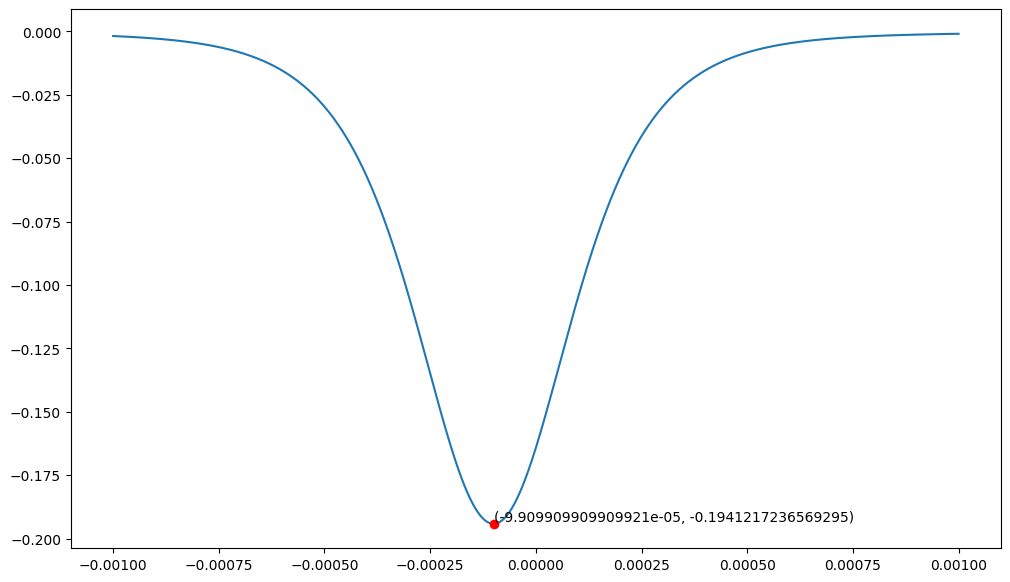

In [38]:
redtrap = red_system(trap)  
redtrap.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))
voltage = np.zeros((16, 1))
voltage[15, 0] = -1
redtrap.volt = voltage
print(minimize(lambda t: redtrap.getPot(t, 0), 300e-6))

x = np.linspace(-1e-3, 1e-3, 1000)
redtrap.getPot(np.array([100e-6]), 0)

pot = redtrap.getPot(x, 0)         # potential array
idx_min = np.argmin(pot)           # index of minimum value
x_min = x[idx_min]                 # x-value at minimum
pot_min = pot[idx_min]              # minimum potential value

print('---------------')
print("x_min:", x_min)
print("y_min:", pot_min)

plt.figure(figsize = (12, 7))
plt.plot(x, redtrap.getPot(x, 0))
plt.plot(x_min, pot_min, 'ro')
plt.text(x_min, pot_min, f'({x_min}, {pot_min})', ha='left', va='bottom')
plt.show()

In [39]:
hbar = 6.62607015e-34 / 2 / np.pi
omega = 9.83511943e+06
hbar_omega = hbar * omega

# in eV
hbar_omega = hbar_omega / 1.602176634e-19

# Precompensation

## Algorithm

In [47]:
class FilterSimulation():

    def __init__(self):
        self.filter_constant = 0.0000175 # 17.5 hardware constraint on filter
        self.time_step =  0.00000038 # 0.38 DAQ time step constraint

    def filter(self):
        # load kernel:
        filter_kernel = np.load('filter_data.npy')
        samples = len(filter_kernel) # 300

        original_time = np.linspace(0, self.filter_constant, samples)

        target_samples = int(self.filter_constant / self.time_step) # 17.5 / 0.38 = 46
        compressed_time = np.linspace(0, self.filter_constant, target_samples) 

        # interpolate to get kernel to length 17.5 µs:
        interpolator = interp1d(original_time, filter_kernel, kind = 'cubic')
        compressed_kernel = interpolator(compressed_time)

        # get impulse response
        impulse_response = np.diff(compressed_kernel, prepend = 0)
        
        return impulse_response

    def pre_setup(self, waveform, waveform_size, wait_time):
        if waveform[0] != 0:
            waveform -= waveform[0]

        total_time = len(waveform) * self.time_step
        half_len = len(waveform) // 2

        # first and second halves of original
        rise = waveform[:half_len]
        fall = waveform[half_len:]

        # time arrays for rise and fall
        time_rise = np.linspace(0, total_time/2, half_len)
        time_fall = np.linspace(total_time/2 + wait_time, total_time + wait_time, half_len)

        # constant plateau section
        plateau_value = rise[-1]
        plateau_points = int(wait_time / self.time_step)
        time_plateau = np.linspace(time_rise[-1], time_rise[-1] + wait_time, plateau_points)
        plateau = np.full(plateau_points, plateau_value)

        # combine all
        time_array = np.concatenate([time_rise, time_plateau, time_fall])
        waveform_combined = np.concatenate([rise, plateau, fall])
        waveform_combined *= waveform_size # scale voltages as needed

        return time_array, waveform_combined

    def setup(self, time_array, waveform, compress, pad):
        compressed_time = time_array / compress
        dense_waveform = np.interp(time_array, compressed_time, waveform)

        mask = 0
        for i in range(0, len(compressed_time)):
            if time_array[i] <= compressed_time[-1]:
                mask += 1
            else:
                break
        masked_waveform = dense_waveform[:mask]

        original = np.pad(masked_waveform, pad_width = pad, mode = 'edge')
        time = np.arange(len(original)) * self.time_step

        return time, original

    def convolution(self, waveform):
        impulse_response = self.filter()
        filtered_waveform = np.convolve(waveform, impulse_response, mode = 'full')
        return filtered_waveform
    
    def interpolation(self, time, shift, filtered):
        interp_func = interp1d(shift, filtered, kind='cubic', bounds_error=False, fill_value="extrapolate")
        filtered_interp = interp_func(time)  # Now same length as time_original
        return filtered_interp
    
    def plotter(self, original, time, filtered, precompensated_unfiltered, precompensated_filtered):
        plt.figure()
        plt.plot(time, original, label = 'Original')
        plt.plot(time, filtered, label = 'Filtered')
        plt.plot(time, precompensated_unfiltered, label = 'Precompensated Unfiltered', linestyle = '--')
        plt.plot(time, precompensated_filtered, label = 'Precompensated Filtered', linestyle = '--')
        plt.title('Filter Waveforms')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def scatter_plot(self, time, precompensated):
        plt.figure()
        plt.plot(time, precompensated, label = 'Full Plot', color = 'red')
        plt.scatter(time, precompensated, label = 'Scattered Plot', color = 'pink')
        plt.title('Precompensated Filtered Waveform')
        plt.xlabel('Time in µs')
        plt.ylabel('Voltage')
        plt.grid(True)
        plt.legend()
        plt.show()

    def precompensation(self, waveform, reg, pad):
        impulse_response = self.filter()
        total_length = max(len(impulse_response), len(waveform)) + 2 * pad

        left_pad = pad
        right_pad_ir = max(0, total_length - len(impulse_response) - pad)
        right_pad_waveform = max(0, total_length - len(waveform) - pad)

        ir_padded = np.pad(impulse_response, (left_pad, right_pad_ir), mode='constant')
        waveform_padded = np.pad(waveform, (left_pad, right_pad_waveform), mode='constant', constant_values = waveform[-1])

        G = fft(ir_padded)
        h_t = waveform_padded
        h_w = fft(h_t)

        G_magnitude = np.abs(G) # amplitude attenuation
        G_phase = np.angle(G) # phase shift

        # Tikhonov regularization: prevents division by zeros or near-zeros
        regularized_magnitude = G_magnitude / (G_magnitude**2 + reg)
        regularized_G = regularized_magnitude * np.exp(-1j * G_phase)

        f_w = h_w * regularized_G
        f_t = np.real(ifft(f_w))

        return f_t

    def trimming(self, original, precompensated, pad):
        for i in range(0, int(pad*0.5)):
            precompensated[i] = original[0]     
        for i in range(len(precompensated) - int(pad*0.5), len(precompensated)):
            precompensated[i] = original[-1]
        return precompensated
    
class Optimize():
    
    def __init__(self):
        self.padding_range = list(range(10, 31))
        self.reg_exponents = list(range(-6, 0))   
        self.reg_coeff = list(range(1, 8))
        self.compression_range = list(range(1, 12))
        
        self.lower_voltage_bound = -40
        self.upper_voltage_bound = 40
        self.time_step = 0.00000038

        self.alpha = 1.00 # <-- weight of max abs error
        self.beta = 0.01 # <-- weight of length

    def optimizer(self, time_array, waveform):
        best_penalty = float('inf')
        best_params = (None, None, None, None, None) # compression, padding, reg_strength, penalty, bounds
        all_best_params = []
        reg_array = []
        
        # generate all possibilities:
        compress = 1
        # for k, compress in enumerate(self.compression_range):
        for i, pad in enumerate(self.padding_range):
            for j, reg in enumerate(self.reg_exponents):
                for l, coeff in enumerate(self.reg_coeff):
                    reg_strength = coeff * 10 ** reg

                    time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

                    # filtering:
                    precompensated = FilterSimulation().precompensation(original, reg_strength, pad)
                    precompensated = precompensated[:len(original)]
                    precompensated = FilterSimulation().trimming(original, precompensated, pad)
                    precompensated_filtered = FilterSimulation().convolution(precompensated)
                    shift_p = np.arange(len(precompensated_filtered)) * self.time_step
                    precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)
                    
                    # results:
                    error = np.max(np.abs(original - precompensated_filtered))
                    length_penalty = (2 * pad + len(original)) / compress
                    penalty = self.alpha * error + self.beta * length_penalty #self.alpha * error + self.beta * pad - self.gamma * compress

                    # print(f'Pad: {pad}, Compress: {compress}, Reg: {reg_strength}, Error: {error}')
                    
                    if np.max(precompensated) > self.upper_voltage_bound or np.min(precompensated) < self.lower_voltage_bound:
                        bounds = 1
                    else:
                        bounds = 0

                    if bounds == 0:
                        if penalty < best_penalty:
                            best_penalty = penalty
                            best_params = (compress, pad, reg_strength, penalty, bounds)
                            all_best_params.append(best_params)

                    if len(reg_array) < (len(self.reg_coeff) * len(self.reg_exponents)):
                        reg_array.append(reg_strength)

        valid_results = [res for res in all_best_params if res[4] == 0]
        if not valid_results:
            print("No valid results found within bounds! Returning least-penalty violating case.")
            best_params = min(all_best_params, key = lambda x: x[3])
        else:
            best_params = min(valid_results, key = lambda x: x[3])
        
        return best_params, reg_array
    
    def get_grids(self, time_array, waveform, best_params):
        compression_grids = {}
        compress = best_params[0]

        error_grid = np.full((len(self.padding_range), len(self.reg_exponents) * len(self.reg_coeff)), np.nan)
        bounds_grid = np.full((len(self.padding_range), len(self.reg_exponents) * len(self.reg_coeff)), np.nan)
        
        for i, pad in enumerate(self.padding_range):
            reg_index = 0
            for j, reg in enumerate(self.reg_exponents):
                for l, coeff in enumerate(self.reg_coeff):
                    reg_strength = coeff * 10 ** reg

                    time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

                    # filtering:
                    precompensated = FilterSimulation().precompensation(original, reg_strength, pad)
                    precompensated = precompensated[:len(original)]
                    precompensated = FilterSimulation().trimming(original, precompensated, pad)
                    precompensated_filtered = FilterSimulation().convolution(precompensated)
                    shift_p = np.arange(len(precompensated_filtered)) * self.time_step
                    precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

                    # results:
                    error = np.max(np.abs(original - precompensated_filtered))
                    length_penalty = (2 * pad + len(original)) / compress
                    penalty = self.alpha * error + self.beta * length_penalty

                    if np.max(precompensated) > self.upper_voltage_bound or np.min(precompensated) < self.lower_voltage_bound:
                        bounds = 1
                    else:
                        bounds = 0

                    error_grid[i, reg_index] = error
                    bounds_grid[i, reg_index] = bounds
                    reg_index += 1

        compression_grids[compress] = (error_grid.copy(), bounds_grid.copy())
        return compression_grids
                        
    def heatmap(self, best_params, compression_grids, reg_array):
        compress = best_params[0]
        pad = best_params[1]
        reg = best_params[2]
        error_grid, bounds_grid = compression_grids[compress]

        plt.figure(figsize = (12, 7))
        
        cmap = sns.color_palette("coolwarm", as_cmap = True)
        ax = sns.heatmap(
            error_grid,
            yticklabels = self.padding_range[::10],  # compression values
            cmap = cmap,
            cbar_kws = {'label': 'Error (in V)'},
            annot = False, # set to true for values displayed on each cell
            fmt = '.2e', # scientific notation format for annotations
        )

        # gray overlay where bounds = 1:
        overlay = np.where(bounds_grid == 1, 1, np.nan)  # 1 where out of bounds, NaN elsewhere
        sns.heatmap(
            overlay,
            mask = np.isnan(overlay),
            cmap = mcolors.ListedColormap([(0.5, 0.5, 0.5, 0.8)]),  # gray with alpha = 0.8
            cbar = False,
            ax = ax
        )

        plt.title(f'Heatmap at Compression x{compress}')
        plt.xlabel('Regularization Strength')
        plt.ylabel('Padding Samples')

        n_yticks = 7
        ytick_positions = np.linspace(0, len(self.padding_range) - 1, n_yticks, dtype = int)
        plt.yticks(ytick_positions, [self.padding_range[i] for i in ytick_positions])
        
        n_xticks = 12
        xtick_positions = np.linspace(0, len(reg_array) - 1, n_xticks, dtype = int)
        labels = [f'{coeff}e{exponent}' for exponent in self.reg_exponents for coeff in self.reg_coeff]
        selected_labels = [labels[i] for i in xtick_positions]
        plt.xticks(xtick_positions, selected_labels, rotation = 45)

        ax.grid(False)
        rect = patches.Rectangle((reg_array.index(reg), self.padding_range.index(pad)), 1, 1, fill = False, edgecolor = 'gold', lw = 3)
        ax.add_patch(rect)
        plt.tight_layout()
        plt.show()

    def error_plotter(self, time, original, precompensated_filtered, best_params):
        rmse = np.sqrt(mean_squared_error(original, precompensated_filtered)) # average error across all points (precompensation is off by about -- volts)
        pointwise_error = np.abs(original - precompensated_filtered) # worst deviation point in the waveform 

        compress = best_params[0]
        pad = best_params[1]
        reg = best_params[2]
        best_penalty = best_params[3]
        
        print('----------------------------------------------------')
        print(f'The best padding is:', pad)
        print(f'The best regularization is: {reg:.0e}')
        print(f'The best compression is: {compress}')
        print(f'The best penalty is: {best_penalty}')
        print(f"Root Mean Squared Error (RMSE): {rmse:.3f} V")
        print(f"Max Absolute Error: {np.max(pointwise_error):.3f} V")

        # absolute error over time:
        plt.plot(time, pointwise_error, color='red', label='|Original - Precompensated Filtered|')
        plt.title('Error between Original and Precompensated Filtered Signal')
        plt.xlabel('Time in µs')
        plt.ylabel('Absolute Error (V)')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

    def tradeoff_plot(self, time_array, waveform, best_params):
        error_array = []
        compression_array = []
        pad = best_params[1]
        reg = best_params[2]
        
        for k, compress in enumerate(self.compression_range):
            time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

            # filtering:
            precompensated = FilterSimulation().precompensation(original, reg, pad)
            precompensated = precompensated[:len(original)]
            precompensated = FilterSimulation().trimming(original, precompensated, pad)
            precompensated_filtered = FilterSimulation().convolution(precompensated)
            shift_p = np.arange(len(precompensated_filtered)) * self.time_step
            precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)
            
            # results:
            error = np.max(np.abs(original - precompensated_filtered))
            compression_array.append(compress)
            error_array.append(error)

        plt.plot(compression_array, error_array)
        plt.xlabel("Compression")
        plt.ylabel("Max Absolute Error")
        plt.title("Compression vs. Max Error")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def exc_comp_plotter(self, time_array, waveform):
        reg_array = []
        best_best_params_abs = []

        for k, compress in enumerate(self.compression_range):
            best_penalty = float('inf')
            best_current_params = (None, None, None)  # compress, pad, reg_strength
            best_params_abs = [] # compression, pad, reg_strength
            all_best_params = []
            
            for i, pad in enumerate(self.padding_range):
                for j, reg in enumerate(self.reg_exponents):
                    for l, coeff in enumerate(self.reg_coeff):
                        reg_strength = coeff * 10 ** reg

                        time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

                        # filtering:
                        precompensated = FilterSimulation().precompensation(original, reg_strength, pad)
                        precompensated = precompensated[:len(original)]
                        precompensated = FilterSimulation().trimming(original, precompensated, pad)
                        precompensated_filtered = FilterSimulation().convolution(precompensated)
                        shift_p = np.arange(len(precompensated_filtered)) * self.time_step
                        precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

                        if len(reg_array) < (len(self.reg_coeff) * len(self.reg_exponents)):
                            reg_array.append(reg_strength)

                        error = np.max(np.abs(original - precompensated_filtered))
                        length_penalty = (2 * pad + len(original)) / compress
                        penalty = self.alpha * error + self.beta * length_penalty

                        if penalty < best_penalty:
                            best_penalty = penalty
                            best_current_params = (compress, pad, reg_strength, penalty)
                            all_best_params.append(best_current_params)

            best_current_params = min(all_best_params, key = lambda x: x[3])
            best_params_abs.append(best_current_params)
            best_best_params_abs.append(best_params_abs)

        return best_best_params_abs
    
class Energize():
    
    def optimize_strength(self, redramp):
        all_best_cases = []
        best_case = (None, None)
        best_energy = float('inf')

        for i in range(1, 10):
            for j in range(8, 12):

                strength = i*10**-j

                transport = np.zeros((17, len(redramp[0])), dtype=np.float64)
                transport[[0, 15, 16]] = redramp

                redtrap = red_system(trap)  
                redtrap.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))

                t, p = redtrap.propagate(transport, transport[0, -1], strength)

                volt = redtrap.getPot(p[-1, :, 0, 0], -1)
                volt0 = redtrap.getPot(p[0, :, 0, 0], 0)

                c = 299792458
                massunit = 931.49410242e6/c**2
                mCa40 = 39.962590866 * massunit

                energy = volt-volt0 + 0.5 * mCa40 * p[-1, 0, 1, 0]**2
                case = (energy, strength)

                if energy < best_energy:
                    best_energy = energy
                    best_case = (energy, strength)
                    all_best_cases.append(best_case)
        
        chosen_case = min(all_best_cases, key = lambda x: x[0])

        return chosen_case[1] #returns best strength
    
    def get_energy(self, redramp, best_strength):
        transport = np.zeros((17, len(redramp[0])), dtype=np.float64)
        transport[[0, 15, 16]] = redramp

        redtrap = red_system(trap)  
        redtrap.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))

        t, p = redtrap.propagate(transport, transport[0, -1], best_strength)

        volt = redtrap.getPot(p[-1, :, 0, 0], -1)
        volt0 = redtrap.getPot(p[0, :, 0, 0], 0)

        c = 299792458
        massunit = 931.49410242e6/c**2
        mCa40 = 39.962590866 * massunit

        energy = volt-volt0 + 0.5 * mCa40 * p[-1, 0, 1, 0]**2
        return energy

## Setup

In [41]:
redramp = np.load('redramp.npy')

time_array = redramp[0].copy()
waveform_1 = redramp[1].copy()
waveform_2 = redramp[2].copy()

## Use Case

Waveform 1

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


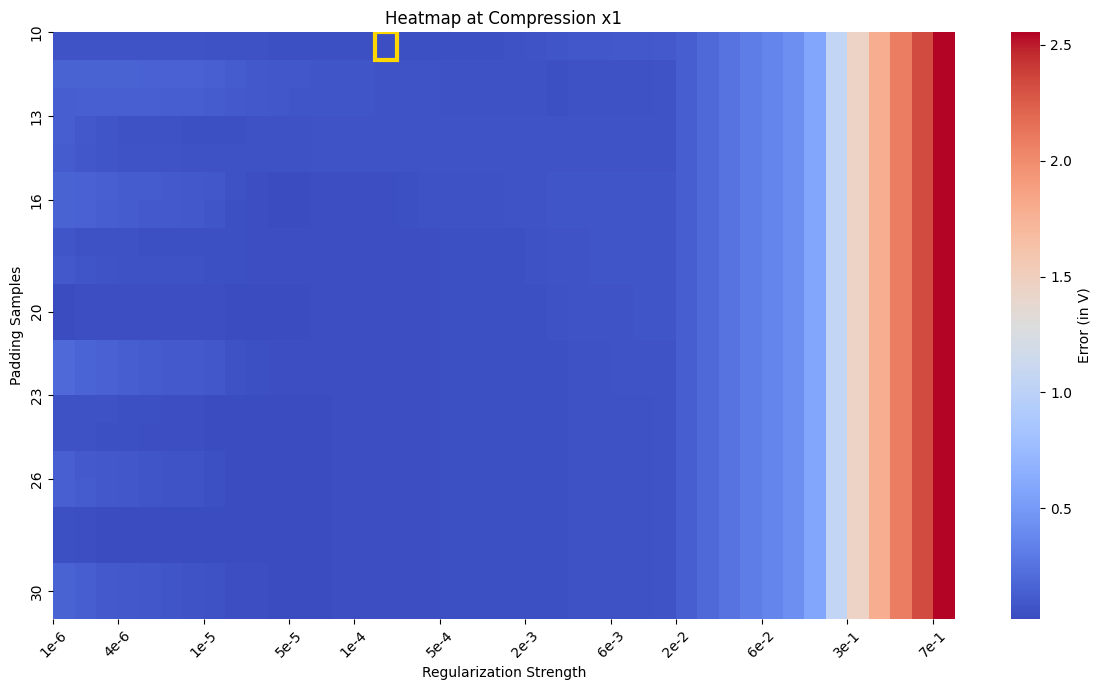

----------------------------------------------------
The best padding is: 10
The best regularization is: 2e-04
The best compression is: 1
The best penalty is: 2.3019788170438744
Root Mean Squared Error (RMSE): 0.009 V
Max Absolute Error: 0.042 V


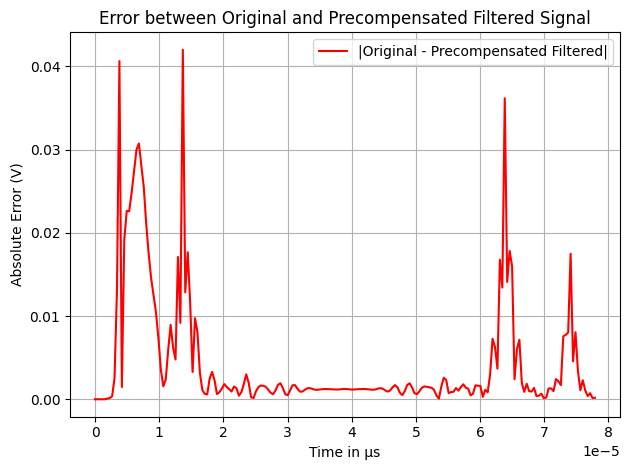

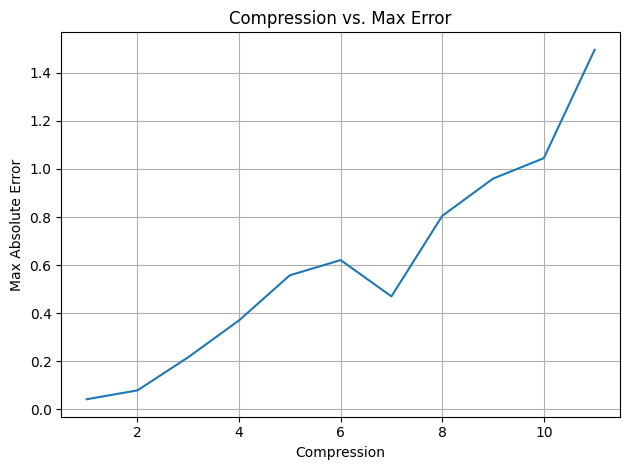

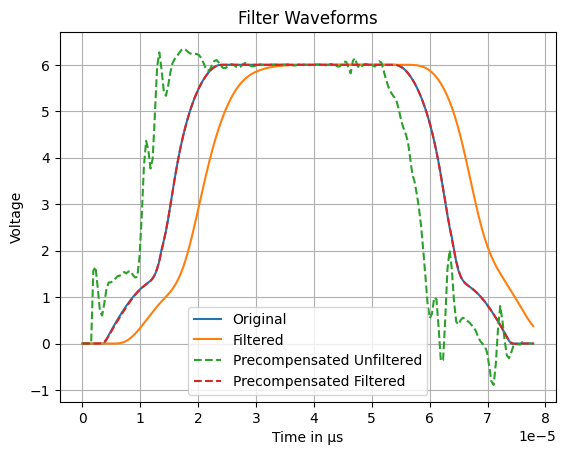

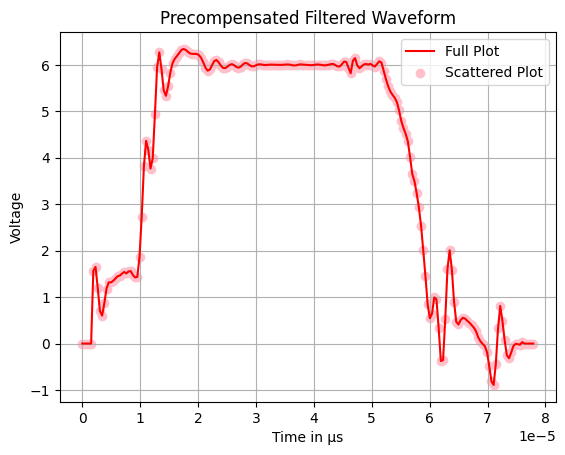

There are 206 points total.


In [42]:
# input data:
waveform_size = 1 # not already normalized
time_step = 0.00000038 # DAQ lower limit
wait_time = 0.00003

# waveform data:
waveform = waveform_1
time_array, waveform = FilterSimulation().pre_setup(waveform, waveform_size, wait_time)

# optimization:
best_params, reg_array = Optimize().optimizer(time_array, waveform)
compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# -- results:
compression_grids = Optimize().get_grids(time_array, waveform, best_params)
Optimize().heatmap(best_params, compression_grids, reg_array)
Optimize().error_plotter(time, original, precompensated_filtered, best_params) # <-- error checker
Optimize().tradeoff_plot(time_array, waveform, best_params)
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)
FilterSimulation().scatter_plot(time, precompensated)
print(f'There are', len(original),'points total.')

# setup for redramp preparation:
new_time = time
waveform_1_orig = precompensated_filtered
waveform_1_precomp = precompensated_unfiltered

Waveform 2

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/seaborn/matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


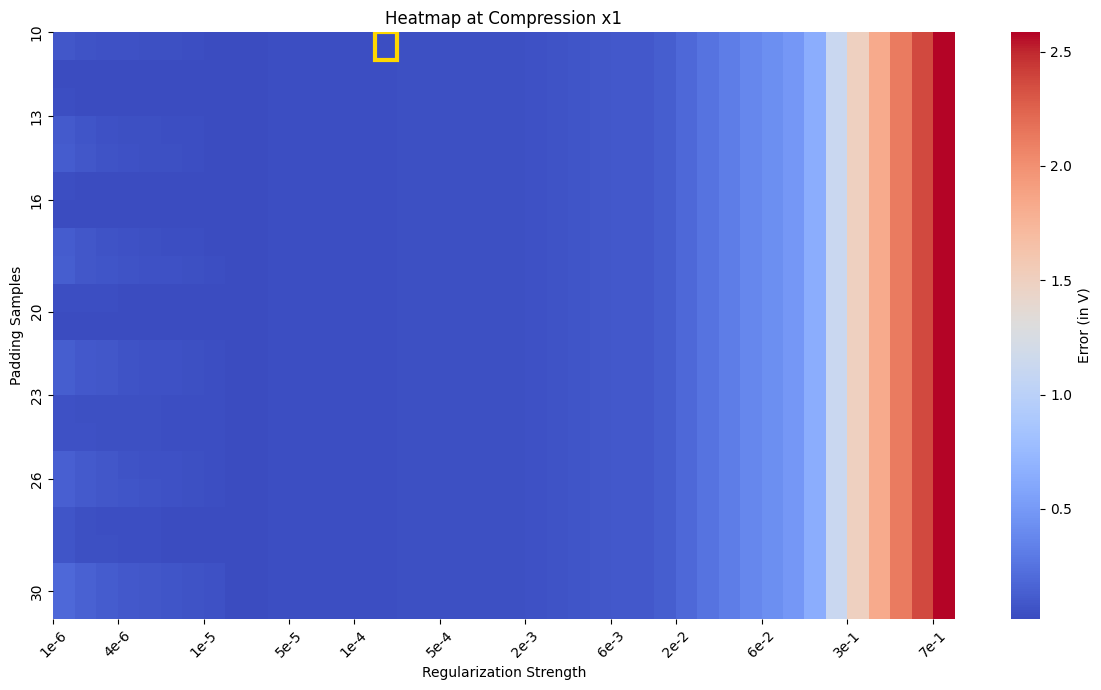

----------------------------------------------------
The best padding is: 10
The best regularization is: 2e-04
The best compression is: 1
The best penalty is: 2.3019788170438744
Root Mean Squared Error (RMSE): 0.006 V
Max Absolute Error: 0.038 V


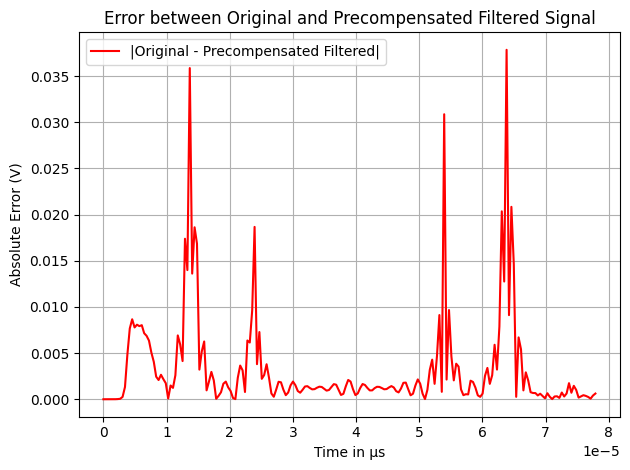

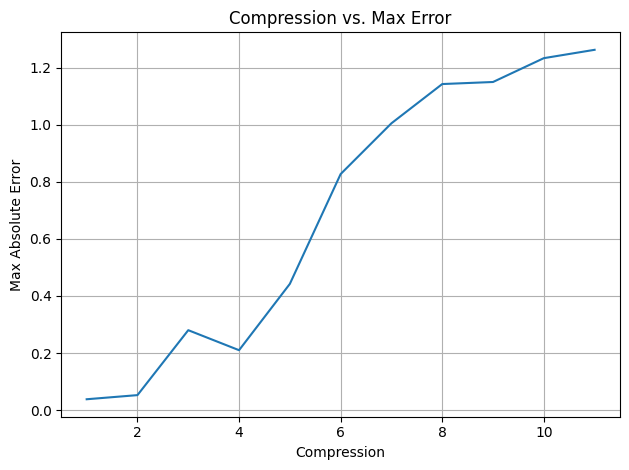

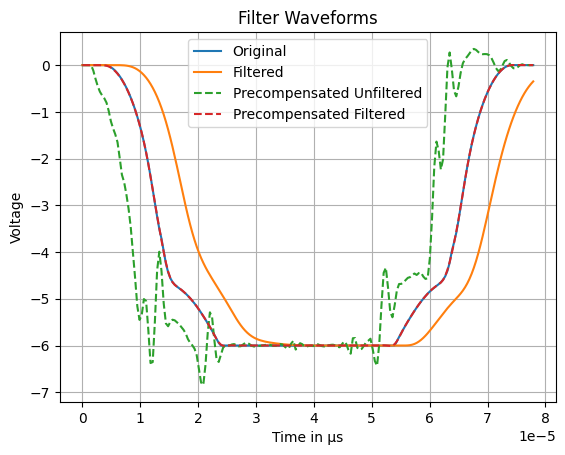

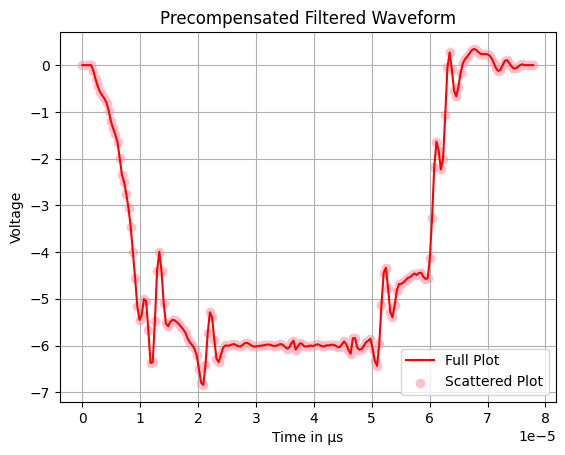

There are 206 points total.


In [43]:
# waveform data:
waveform = waveform_2
time_array, waveform = FilterSimulation().pre_setup(waveform, waveform_size, wait_time)

# already optimized (by waveform 1):
compress = best_params[0]
pad = best_params[1] 
reg = best_params[2]
error = best_params[3]

# setup waveform:
time, original = FilterSimulation().setup(time_array, waveform, compress, pad)

# begin filter simulation:
# -- filtered
filtered = FilterSimulation().convolution(original)
shift_f = np.arange(len(filtered)) * time_step
filtered = FilterSimulation().interpolation(time, shift_f, filtered)

# -- precompensated setup
precompensated = FilterSimulation().precompensation(original, reg, pad)
precompensated = precompensated[:len(original)]
precompensated = FilterSimulation().trimming(original, precompensated, pad)

# -- precompensated filtered
precompensated_filtered = FilterSimulation().convolution(precompensated)
shift_p = np.arange(len(precompensated_filtered)) * time_step
precompensated_filtered = FilterSimulation().interpolation(time, shift_p, precompensated_filtered)

# -- precompensated unfiltered
shift_p_unfiltered = np.arange(len(precompensated)) * time_step
precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

# -- results:
compression_grids = Optimize().get_grids(time_array, waveform, best_params)
Optimize().heatmap(best_params, compression_grids, reg_array)
Optimize().error_plotter(time, original, precompensated_filtered, best_params) # <-- error checker
Optimize().tradeoff_plot(time_array, waveform, best_params)
FilterSimulation().plotter(original, time, filtered, precompensated_unfiltered, precompensated_filtered)
FilterSimulation().scatter_plot(time, precompensated)
print(f'There are', len(original),'points total.')

# setup for redramp preparation:
new_time = time
waveform_2_orig = precompensated_filtered
waveform_2_precomp = precompensated_unfiltered

### New Redramp:

In [44]:
new_redramp = np.array([new_time, (waveform_1_precomp+0.01)-6, waveform_2_precomp+0.01])

### Plotted Output:

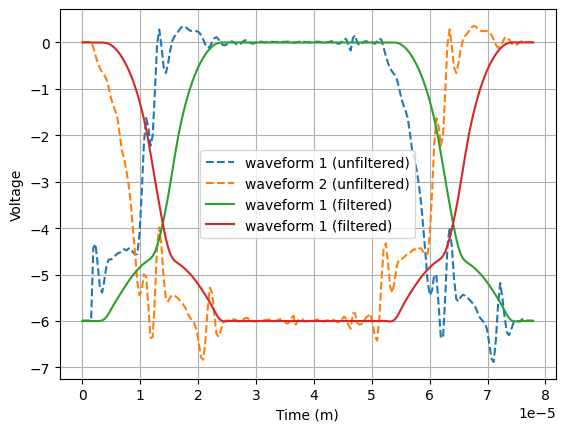

In [45]:
plt.plot(new_redramp[0], new_redramp[1], label = 'waveform 1 (unfiltered)', linestyle = '--')  # <-- must start at 0 (transformed to start at -6 v))
plt.plot(new_redramp[0], new_redramp[2], label = 'waveform 2 (unfiltered)', linestyle = '--')

plt.plot(new_time, waveform_1_orig-6, label = 'waveform 1 (filtered)')
plt.plot(new_time, waveform_2_orig, label = 'waveform 1 (filtered)')

plt.grid(True)
plt.xlabel('Time (m)')
plt.ylabel('Voltage')
plt.legend()
plt.show()

### Excitation:

In [48]:
best_strength = Energize().optimize_strength(new_redramp) # <-- Find BEST Regularization:

In [ ]:
print(best_strength)

In [49]:
energy = Energize().get_energy(new_redramp, best_strength)
print(energy / hbar_omega)

[242.73018911]


(In constrast to original ramp)

In [ ]:
best_strength = Energize().optimize_strength(redramp) # <-- Find BEST Regularization:
energy = Energize().get_energy(redramp, best_strength)
print(energy / hbar_omega)

## Excitation vs Compression

After precompensating waveforms 1 and 2, combine into 3-array redramp: <br> <br>
redramp[0] =  Time Array <br>
redramp[1] =  Waveform 1 <br>
redramp[2] = Waveform 2 <br>

## Builds list of all compression best cases

Define Input Waveform (Redramp):

In [ ]:
redramp = np.load('redramp.npy')

time_array = redramp[0].copy()
waveform_1 = redramp[1].copy()
waveform_2 = redramp[2].copy()

Get Best Parameters per Compression:

In [50]:
waveform_size = 1
time_step = 0.00000038
wait_time = 0.00003

waveform = waveform_1
time_array, waveform = FilterSimulation().pre_setup(waveform, waveform_size, wait_time)
best_best_params_abs = Optimize().exc_comp_plotter(time_array, waveform)

lista = [[],[],[]]

for i in best_best_params_abs:
    lista[0].append(i[0][0]) # compressions
    lista[1].append(i[0][1]) # padding
    lista[2].append(i[0][2]) # regularization

print(lista)

[[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11], [10, 10, 14, 12, 15, 14, 19, 15, 17, 26, 14], [0.0002, 0.0002, 1e-06, 3e-06, 4.9999999999999996e-06, 4e-06, 4.9999999999999996e-06, 3e-06, 1e-05, 1e-06, 3e-06]]


Run for all Cases:

In [52]:
waveform_size = 1
wait_time = 0.00003
time_step = 0.00000038
all_energies = []

# precompensation:
for i in range(0, lista[0][-1]):
    redramp_precompensated = np.array([[], [], []])

    compress = lista[0][i]
    pad = lista[1][i] 
    reg = lista[2][i]
    
    # waveform 1:
    time, original = FilterSimulation().setup(time_array.copy(), waveform.copy(), compress, pad)
    precompensated = FilterSimulation().precompensation(original, reg, pad)    
    precompensated = precompensated[:len(original)]    
    precompensated = FilterSimulation().trimming(original, precompensated, pad)
    shift_p_unfiltered = np.arange(len(precompensated)) * time_step
    precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)
    waveform_1_precomp = precompensated_unfiltered

    # waveform 2:
    waveform = waveform_2
    time_array, waveform = FilterSimulation().pre_setup(waveform, waveform_size, wait_time)

    time, original = FilterSimulation().setup(time_array, waveform, compress, pad)
    precompensated = FilterSimulation().precompensation(original, reg, pad)    
    precompensated = precompensated[:len(original)]    
    precompensated = FilterSimulation().trimming(original, precompensated, pad)
    precompensated_unfiltered = FilterSimulation().interpolation(time, shift_p_unfiltered, precompensated)

    waveform_2_precomp = precompensated_unfiltered

    redramp_precompensated = np.array([time, waveform_1_precomp+0.01, waveform_2_precomp+0.01])

# excitation:
    redramp = redramp_precompensated

    transport = np.zeros((17, len(redramp[0])), dtype=np.float64)
    transport[[0, 15, 16]] = redramp

    redtrap = red_system(trap)  
    redtrap.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))

    t, p = redtrap.propagate(transport, transport[0, -1], 5e-9) # <-- issue

    volt = redtrap.getPot(p[-1, :, 0, 0], -1)
    volt0 = redtrap.getPot(p[0, :, 0, 0], 0)
        
    c = 299792458
    massunit = 931.49410242e6/c**2
    mCa40 = 39.962590866 * massunit

    energy = volt-volt0 + 0.5 * mCa40 * p[-1, 0, 1, 0]**2
    all_energies.append(energy / hbar_omega)
    print(i, energy / hbar_omega)

0 [nan]
1 [1.86411467e+08]
2 [nan]
3 [23961269.43889042]
4 [85843468.61245286]
5 [18971551.94854946]
6 [44186078.38110604]
7 [1.16312859e+08]
8 [nan]
9 [nan]
10 [-3.07092354e+08]


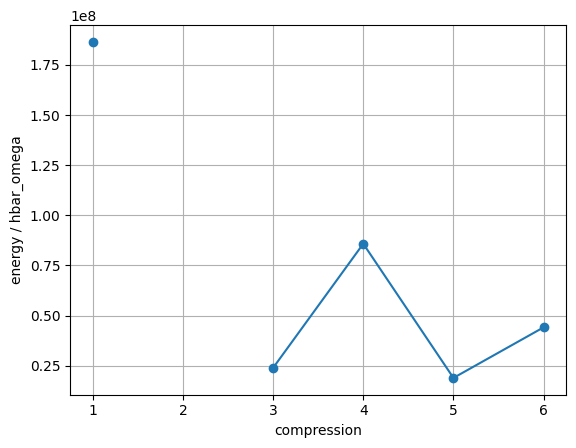

In [32]:
from matplotlib.ticker import MaxNLocator

plt.plot(all_energies, marker = 'o')
plt.gca().xaxis.set_major_locator(MaxNLocator(integer = True)) # integers on x
plt.ylabel('energy / hbar_omega')
plt.xlabel('compression')
plt.grid(True)
plt.show()

## Reconstruct Redramp

In [33]:
precompensated_redramp = np.array([time, waveform_1, waveform_2]) # shape (3, N)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (3,) + inhomogeneous part.

## Now we implement a Transport from segment 15 to segment 16
### Task:
- replace the redramp with a precompensated transport ramp and see what the excitation quanta is
- **double check:**
  - is the ion starting at the middle of the potential of segment 15?
  - is the ion adning at the center of segment 16 when the transport ended?
    (even if so, does it have kinetic energy?)

In [ ]:
result = []
redramp = np.load('redramp.npy')

# transport array is one row bigger than the number of trap segments
# first entry is time 
transport = np.zeros((17, 54), dtype=np.float64)
transport[[0, 15, 16], :54] = redramp[:, :54]
#          |
#          time
#              |
#              segment #15
#                   | 
#                   segment #16


# set Ion at -300um e.g. the center of segment 15 of the redtrap
# ( trap segments are 200um wide each )
redtrap = red_system(trap)  
redtrap.setIons(np.array([[[-300.0e-6],[0],[0]],], dtype=np.float64))

    # propagates / simulates the ion trajectory and give back:
    # t: timesteps 
    # p: ppoints : np.array
    #        ppoints[:, 0, 0, 0]
    #                |  |  |  |
    #                |  |  |  > dimension x (or general 1st dim)
    #                |  |  > 0 is position, 
    #                |  |    1 velocity, 2 acceleration
    #                |  > choose ion #0
    #                > all timesteps

t, p = redtrap.propagate(transport, transport[0, -1], 5e-9)

volt = redtrap.getPot(p[-1, :, 0, 0], -1)
volt0 = redtrap.getPot(p[0, :, 0, 0], 0)
    
    
# masse u in eV
c = 299792458# m/s
massunit = 931.49410242e6/c**2 # eV * s^2 / m^2
mCa40 = 39.962590866 * massunit

# energy in eV
energy = volt-volt0 + 0.5 * mCa40 * p[-1, 0, 1, 0]**2

# Print excitation quanta
print(energy / hbar_omega)

[66.14594398]


### Plot result <a id="restheory"></a>

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

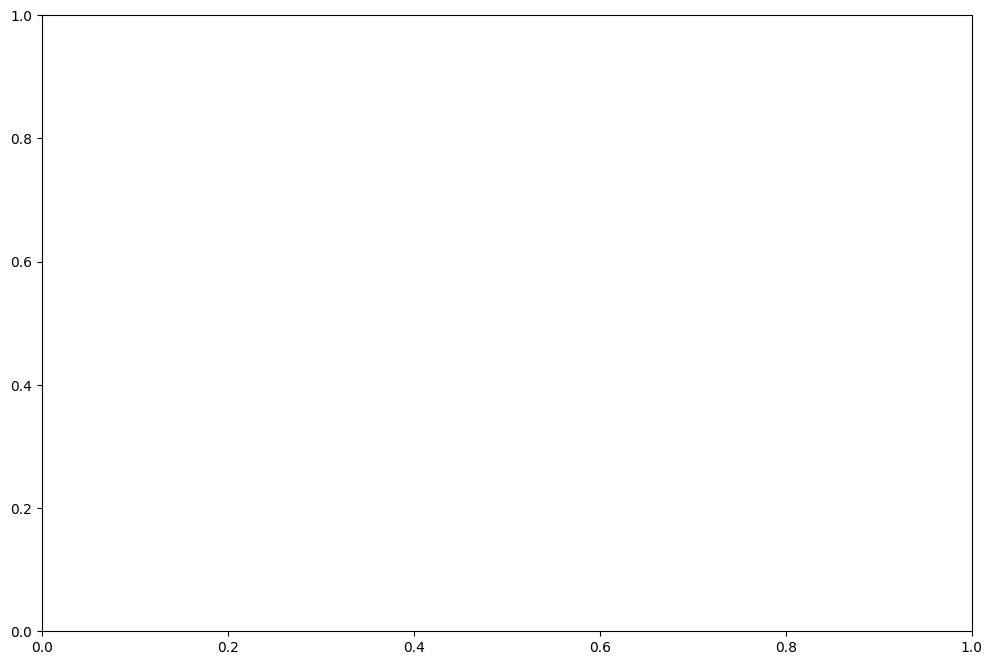

In [ ]:
r = np.array(result)
fig, ax = plt.subplots(figsize=(12,8))
pc = ax.pcolormesh(r[:, 0].reshape((-1, 30))*1e6, 
                   r[:, 1].reshape((-1, 30))*20, 
                   r[:, 2].reshape((-1, 30))/hbar_omega, cmap='coolwarm')

cbar = fig.colorbar(pc)
cbar.set_label(r'n [$\hbar\omega$]')
ax.set_title('Ion excitation')
ax.set_xlabel("dwelltime [us]")
ax.set_ylabel("transporttime [us]")